# Transfer learning and fine tuning for image classification

## Transfer learning

### Importing the libraries

In [3]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
tf.__version__

'2.9.2'

### Loading the images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/Computer Vision Masterclass/Datasets/natashatony'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

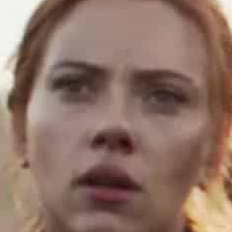

In [6]:
tf.keras.preprocessing.image.load_img('/content/training_set/Natasha_Romanoff/Natasha_Romanoff103.png')

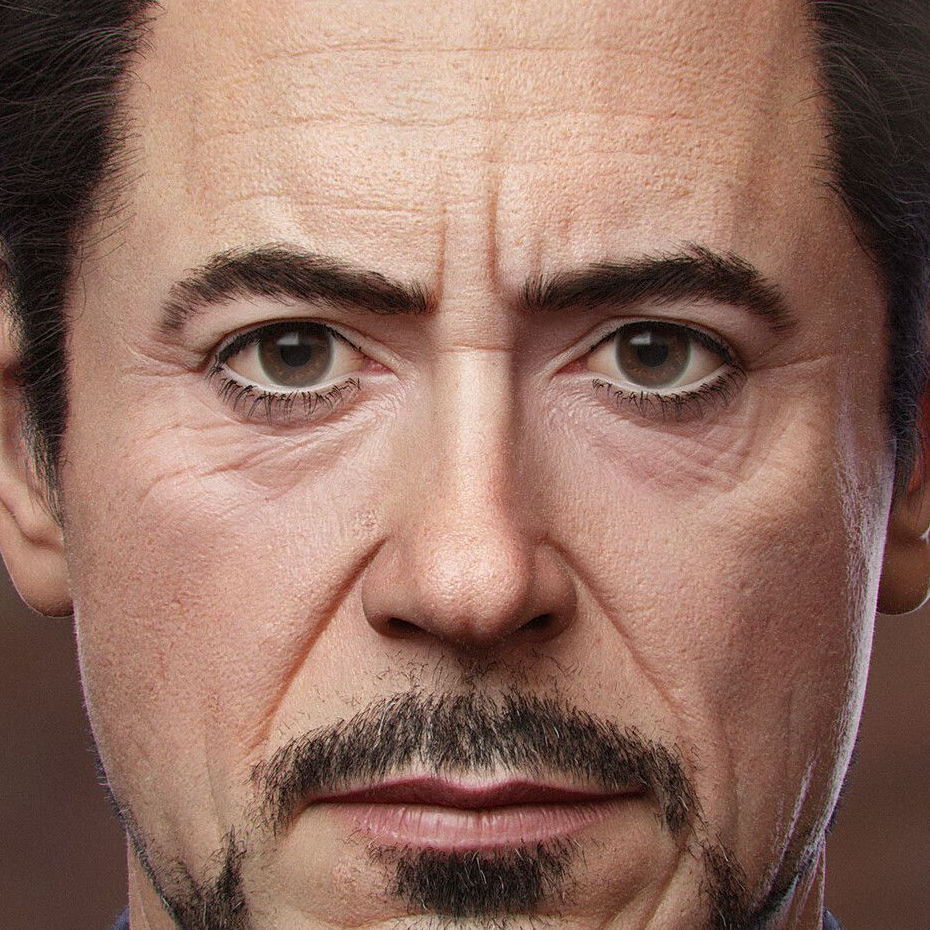

In [8]:
tf.keras.preprocessing.image.load_img('/content/training_set/tony_stark/tony_stark103.png')

### Train and test set

In [10]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/training_set',
                                                        target_size = (256, 256),
                                                        batch_size = 8,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 144 images belonging to 2 classes.


In [11]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [12]:
train_dataset.class_indices

{'Natasha_Romanoff': 0, 'tony_stark': 1}

In [14]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/test_set',
                                                     target_size = (256, 256),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 56 images belonging to 2 classes.


### Pre-trained network

- ResNet: https://arxiv.org/pdf/1512.03385.pdf
- Documentation: https://keras.io/api/applications/

In [15]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 [==============================] - 5s 0us/step


In [17]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [18]:
len(base_model.layers)

175

In [19]:
for layer in base_model.layers:
  layer.trainable = False

In [20]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f21d3b1c8b0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f21d3b0fc40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f21d22e1f40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21d22e15b0> False
<keras.layers.core.activation.Activation object at 0x7f21d22e1850> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f21d21dca30> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f21d1d65700> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f21d2212d00> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21d1d65d30> False
<keras.layers.core.activation.Activation object at 0x7f21d1d6c0d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f21d1d7e8b0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21d1d03d00> False
<keras.layers.c

### Custom dense layer

In [21]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [22]:
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

### Building and training the neural network

In [23]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [24]:
network = Model(inputs = base_model.input, outputs = head_model)

In [25]:
8 * 8 * 2048

131072

In [26]:
(2048 + 2) / 2

1025.0

In [27]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [28]:
network.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
18/18 [==============================] - 12s 152ms/step - loss: 1.3947 - accuracy: 0.5000
Epoch 2/50
18/18 [==============================] - 3s 155ms/step - loss: 0.7599 - accuracy: 0.4861
Epoch 3/50
18/18 [==============================] - 3s 147ms/step - loss: 0.6869 - accuracy: 0.5417
Epoch 4/50
18/18 [==============================] - 3s 150ms/step - loss: 0.7742 - accuracy: 0.5139
Epoch 5/50
18/18 [==============================] - 3s 147ms/step - loss: 0.7258 - accuracy: 0.5347
Epoch 6/50
18/18 [==============================] - 3s 147ms/step - loss: 0.7023 - accuracy: 0.5208
Epoch 7/50
18/18 [==============================] - 3s 146ms/step - loss: 0.7196 - accuracy: 0.4722
Epoch 8/50
18/18 [==============================] - 3s 151ms/step - loss: 0.6925 - accuracy: 0.5486
Epoch 9/50
18/18 [==============================] - 3s 146ms/step - loss: 0.7045 - accuracy: 0.5694
Epoch 10/50
18/18 [==============================] - 3s 139ms/step - loss: 0.6970 - accuracy: 0.513

### Evaluating the neural network

In [30]:
test_dataset.class_indices

{'Natasha_Romanoff': 0, 'tony_stark': 1}

In [31]:
predictions = network.predict(test_dataset)
predictions

56/56 [==============================] - 2s 11ms/step


array([[0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.48253733, 0.5174627 ],
       [0.

In [32]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [34]:
# Approach 1 (all pixels): 0.68
# Approach 2 (features): 0.88
# Approach 3 (CNN): 0.92
# Approach 4 (Transfer learning): 0.81
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.44642857142857145

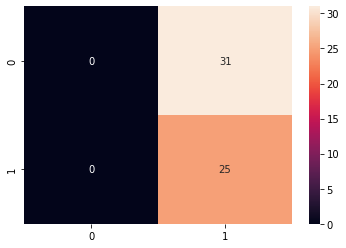

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [36]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.45      1.00      0.62        25

    accuracy                           0.45        56
   macro avg       0.22      0.50      0.31        56
weighted avg       0.20      0.45      0.28        56



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fine tuning

### Implementing

In [37]:
base_model.trainable = True

In [38]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f21d3b1c8b0> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f21d3b0fc40> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f21d22e1f40> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21d22e15b0> True
<keras.layers.core.activation.Activation object at 0x7f21d22e1850> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f21d21dca30> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f21d1d65700> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f21d2212d00> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21d1d65d30> True
<keras.layers.core.activation.Activation object at 0x7f21d1d6c0d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f21d1d7e8b0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21d1d03d00> True
<keras.layers.core.activati

In [39]:
len(base_model.layers)

175

In [40]:
fine_tuning_at = 140

In [41]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [42]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
18/18 [==============================] - 7s 144ms/step - loss: 0.8879 - accuracy: 0.5347
Epoch 2/50
18/18 [==============================] - 3s 145ms/step - loss: 0.7378 - accuracy: 0.5139
Epoch 3/50
18/18 [==============================] - 3s 143ms/step - loss: 0.7154 - accuracy: 0.4861
Epoch 4/50
18/18 [==============================] - 3s 144ms/step - loss: 0.6931 - accuracy: 0.5139
Epoch 5/50
18/18 [==============================] - 3s 148ms/step - loss: 0.6887 - accuracy: 0.5486
Epoch 6/50
18/18 [==============================] - 3s 154ms/step - loss: 0.6945 - accuracy: 0.5625
Epoch 7/50
18/18 [==============================] - 3s 145ms/step - loss: 0.6050 - accuracy: 0.6875
Epoch 8/50
18/18 [==============================] - 3s 147ms/step - loss: 0.6137 - accuracy: 0.7222
Epoch 9/50
18/18 [==============================] - 3s 149ms/step - loss: 0.5623 - accuracy: 0.7014
Epoch 10/50
18/18 [==============================] - 3s 145ms/step - loss: 0.6174 - accuracy: 0.6736

### Evaluate 

In [44]:
predictions = network.predict(test_dataset)
predictions

56/56 [==============================] - 1s 13ms/step


array([[4.88984376e-01, 5.11015654e-01],
       [9.00256038e-01, 9.97439697e-02],
       [8.89602125e-01, 1.10397890e-01],
       [1.06323719e-01, 8.93676341e-01],
       [8.46594155e-01, 1.53405860e-01],
       [8.43918204e-01, 1.56081781e-01],
       [9.12978590e-01, 8.70214552e-02],
       [7.61941850e-01, 2.38058150e-01],
       [6.19783640e-01, 3.80216390e-01],
       [6.21611059e-01, 3.78388971e-01],
       [5.34007430e-01, 4.65992630e-01],
       [4.53568310e-01, 5.46431661e-01],
       [9.80446398e-01, 1.95535906e-02],
       [8.58348906e-01, 1.41651064e-01],
       [6.12473309e-01, 3.87526691e-01],
       [9.74919379e-01, 2.50806101e-02],
       [6.13320231e-01, 3.86679798e-01],
       [1.34055585e-01, 8.65944445e-01],
       [5.00681520e-01, 4.99318510e-01],
       [9.02933896e-01, 9.70660597e-02],
       [8.41973722e-01, 1.58026248e-01],
       [9.35302675e-01, 6.46973029e-02],
       [9.38487768e-01, 6.15122132e-02],
       [8.64006519e-01, 1.35993510e-01],
       [3.204830

In [45]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [46]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [85]:
# Approach 1 (all pixels): 0.68
# Approach 2 (features): 0.88
# Approach 3 (CNN): 0.92
# Approach 4 (Transfer learning): 0.81
# Approach 4 (Fine tuning): 0.85
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.8571428571428571

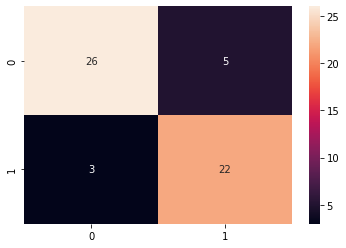

In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [87]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.81      0.88      0.85        25

    accuracy                           0.86        56
   macro avg       0.86      0.86      0.86        56
weighted avg       0.86      0.86      0.86        56



## Saving and loading the model

In [48]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [49]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [50]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer

In [51]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [52]:
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Classifying one single image

In [74]:
image = cv2.imread('/content/test_set/tony_stark/tony_stark9.png')

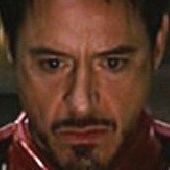

In [75]:
cv2_imshow(image)

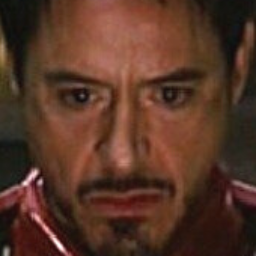

In [76]:
image = cv2.resize(image, (256, 256))
cv2_imshow(image)

In [77]:
image

array([[[11, 18, 15],
        [11, 17, 13],
        [11, 17, 12],
        ...,
        [17, 23, 22],
        [19, 24, 24],
        [21, 26, 27]],

       [[12, 18, 16],
        [12, 18, 15],
        [12, 17, 14],
        ...,
        [17, 22, 22],
        [19, 24, 25],
        [21, 26, 27]],

       [[13, 18, 17],
        [13, 18, 17],
        [13, 18, 17],
        ...,
        [16, 21, 22],
        [20, 25, 25],
        [22, 27, 28]],

       ...,

       [[16, 21, 20],
        [25, 32, 31],
        [44, 54, 52],
        ...,
        [38, 38, 50],
        [51, 51, 62],
        [59, 60, 70]],

       [[17, 22, 20],
        [29, 36, 34],
        [49, 58, 56],
        ...,
        [41, 42, 53],
        [58, 58, 69],
        [70, 71, 80]],

       [[18, 23, 21],
        [32, 38, 36],
        [54, 61, 58],
        ...,
        [43, 44, 54],
        [62, 63, 73],
        [77, 78, 88]]], dtype=uint8)

In [78]:
image = image / 255
image

array([[[0.04313725, 0.07058824, 0.05882353],
        [0.04313725, 0.06666667, 0.05098039],
        [0.04313725, 0.06666667, 0.04705882],
        ...,
        [0.06666667, 0.09019608, 0.08627451],
        [0.0745098 , 0.09411765, 0.09411765],
        [0.08235294, 0.10196078, 0.10588235]],

       [[0.04705882, 0.07058824, 0.0627451 ],
        [0.04705882, 0.07058824, 0.05882353],
        [0.04705882, 0.06666667, 0.05490196],
        ...,
        [0.06666667, 0.08627451, 0.08627451],
        [0.0745098 , 0.09411765, 0.09803922],
        [0.08235294, 0.10196078, 0.10588235]],

       [[0.05098039, 0.07058824, 0.06666667],
        [0.05098039, 0.07058824, 0.06666667],
        [0.05098039, 0.07058824, 0.06666667],
        ...,
        [0.0627451 , 0.08235294, 0.08627451],
        [0.07843137, 0.09803922, 0.09803922],
        [0.08627451, 0.10588235, 0.10980392]],

       ...,

       [[0.0627451 , 0.08235294, 0.07843137],
        [0.09803922, 0.1254902 , 0.12156863],
        [0.17254902, 0

In [79]:
image.shape

(256, 256, 3)

In [80]:
image = image.reshape(-1, 256, 256, 3)
image.shape

(1, 256, 256, 3)

In [81]:
result = network_loaded(image)
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.2505866 , 0.74941343]], dtype=float32)>

In [82]:
result = np.argmax(result)
result

1

In [83]:
test_dataset.class_indices

{'Natasha_Romanoff': 0, 'tony_stark': 1}

In [84]:
if result == 0:
  print('natasha')
else:
  print('tony')

tony
